# FN6815 Numerical Methods for Financial Instrument Pricing

# Lecture 9: Monte Carlo Simulation Pricing

-   Dr. Yang Ye
-   Email: yy@runchee.com
-   2023/2024 Mini Term 5


## 1. Monte Carlo Simulation

Monte Carlo (MC) methods use random numbers to perform simulations, leveraging the statistical properties of the outcomes to estimate results. We've previously used MC methods to calculate the area of a circle, the value of $\pi$, and to perform integration.

The principle behind MC is the expectation value:

$$
\text{Target} = \mathbb{E} = \sum {\text{Probability} \times \text{Outcome}}
$$

Due to the use of pseudo-random variables as input, the results vary based on **the random number sequence** and **the number of iterations**.

The advantage of MC methods is that it can be applied to many kinds of problems, including those with complex conditions or high dimensions input.

The disadvantage is that they can be computationally expensive and may not reach convergence with allowable resources.

The success of MC methods hinges on **reducing the variance of the result** (thus requiring fewer iterations) and **shortening the computation time**.

#### Discussion

-   **Monte Carlo for $\pi$**: Can you write code that uses a Monte Carlo method to calculate $\pi$?

-   **Optimization**: What strategies could we employ to speed up this process?


### 1.1 MC applies to Pricing

Monte Carlo methods can be used to price options through a three-step process:

-   Simulation: Generate **potential future prices** of the underlying asset(s).
-   Payoff Calculation: Determine **the payoff** of the option for each potential price path of the underlying asset(s).
-   Post-processing: Convert the payoffs in the future back to the present, i.e. **discounting** and average them to determine the expected price.

Monte Carlo methods stand out from other option pricing techniques in how they generate potential future asset prices.

-   They can be applied to **any** asset following any stochastic process, provided there's an associated random distribution for sampling.
-   Being simulation-based, they can closely mimic real payoff functions, removing limitations on path-independence. They can handle almost all instruments, though some, like American options, may have computational complexity. You may study further for "Longstaff-Schwartz" for pricing American Option with MC.
-   Monte Carlo methods can also price multi-asset options. The algorithmic complexity is linear with the number of assets, $O(N)$, where N is the number of assets.
-   The trade-off is computational cost and approximation. Precision control is crucial to avoid significant errors.

Learning Objectives

-   Path Generation: Learn how to generate paths from the standard log-normal model of asset prices. This can also be applied to other assets/processes.
-   Variance Reduction: Learn how to measure the variance and various techniques to minimize the number of simulations required to generate an accurate option price.


### 1.2 Pricing by MC in a nut shell

For an asset dynamics, the asset price at time $t$, where $W_t$ follows the normal distribution with mean $0$ and variance $t$, i.e., $W_t = \sqrt{t} z$, is given by:

$$
{S_t} = {S_0} e ^ {(\mu -\frac{\sigma ^2}{2})dt+\sigma W_t} \\
\downarrow \\
{S_t} = {S_0} e ^ {(\mu -\frac{\sigma ^2}{2})dt+\sigma \sqrt{t} z} \\
$$

The $\text{Payoff}$ function is calculated with the input of asset price from initial to the end ${S_0} \ldots {S_t}$, and/or other parameters (volatility, risk-free rate).

We can simplify the notation of the PayOff function with the primary input, the random variable, $z$:

$$
\text{Payoff}(z, t, \sigma, \mu, ....) \rightarrow \text{PayOff}(z)
$$

The present value (PV) is the discounted expectation of the $\text{Payoff}$ function:

$$
PV = \text{discount} \times \mathbb{E}{(\text{Payoff(z)})}
$$

Numerically, the expectation is the average of Payoff over a large set of normally distributed random numbers $z$:

$$
PV = \text{discount} \times \text{Average}{(\text{Payoff}(z)) \text{ for a large number of } z}
$$


### 1.3 Simulation of asset price for GBM

#### Euler-Maruyama Method

The Euler-Maruyama method is used to discretize the continuous process of price. For the Black-Scholes Model, the price follows the expression:

$$
S_{t+dt} = S_t + \mu(S_t, t) dt + \sigma(S_t, t) dW
$$

This equation approximates $S_{t+dt}$ with a forward scheme, truncated from Taylor expansion. Accumulating $\Delta t$ to get $S_T$ introduces "timestepping error". To reduce this error, $\Delta t$ must be chosen small enough.

For GBM (unlike other processes), the log-stock price follows:

$$
d ln S_t = (r - \frac 1 2 \sigma ^ 2) dt + \sigma d W_t
$$

This equation is an exact integration of the SDE when $\sigma$, $\mu$ are constant, avoiding the timestepping errors from the Euler-Maruyama method.

To simulate path-dependent payoff at an intermediate time $t_i$, progress from $t_{i}$ to $t_{i+1}$ by internal time $\Delta t$:

$$
S_{i+1} = S_{i} e ^ {(\mu -\frac{\sigma ^2}{2}) {\Delta t} +\sigma \sqrt{\Delta t} z}
$$

For path-independent payoff, go straight to the terminal time at $T$:

$${S_T} = {S_0} e ^ {(\mu -\frac{\sigma ^2}{2}) T +\sigma \sqrt{T} z} $$


Let's implement the Monte Carlo simulation for pricing a European call option with GBM below.

We will leverage on the `numpy` and `scipy` libraries for the simulation.

-   The `scipy.stats` module has the functions `sps.norm.cdf` and `sps.norm.ppf` for the normal distribution.
-   The `numpy.random` module has the function `npr.normal` for generating random numbers from the normal distribution, `npr.lognormal` for the log-normal distribution.

For the use of random number generation, we need to set the seed for reproducibility. It's `npr.seed()`.


In [1]:
S_0 = 100
strike = 100
ttm = 2  # in year
rf = 0.03  # \mu in year
sigma = 0.3  # \sigma, volatility in year/annualized

nBins=40


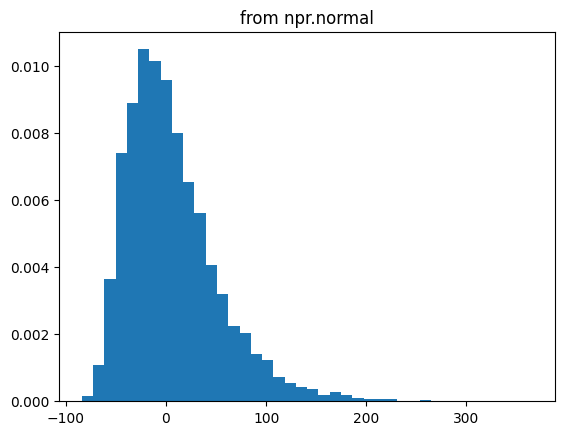

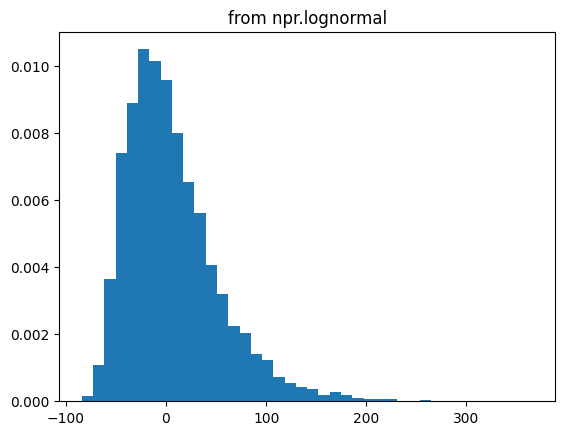

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.stats as sps


def linear_payoff(S_t, strike):
    return S_t - strike


# The GBM formula
def gbm(S_0, rf, sigma, delta_t, z):
    return S_0 * np.exp((rf - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * z)


# The payoff function that uses the final price of the GBM.
def gbm_payoff(S_0, strike, ttm, rf, sigma, payoff_func, z):
    S_t = gbm(S_0, rf, sigma, ttm, z)
    return payoff_func(S_t, strike)


npr.seed(1123)
x = gbm_payoff(S_0, strike, ttm, rf, sigma, linear_payoff, z=npr.normal(size=9999))

npr.seed(1123)
y = (
    S_0 * npr.lognormal((rf - sigma**2 / 2) * ttm, sigma * np.sqrt(ttm), size=9999)
    - strike
)

nBins = int(np.min([np.sqrt(x.size), 40]))
print(f"{nBins=}")
nBins = 40
plt.hist(x, bins=nBins, density=True)
plt.title("from npr.normal")
plt.show()
plt.hist(y, bins=nBins, density=True)
plt.title("from npr.lognormal")
plt.show()

Because `npr.lognormal(loc,s,size)` = `np.exp(loc+s*npr.normal(size=size))`, $x,y$ are generated paths from the same lognorm distribution.

Comparing the two versions, we also utilized different coding styles:

-   `gbm_payoff` breaks down the calculation into multiple steps, which is easier to understand.
-   `npr.lognormal` combines all the steps in one expression

We shall use more the step-by-step style as they are easier to understand, debug and maintain.


In [4]:
np.linspace(0, 6, 10000)

array([0.00000000e+00, 6.00060006e-04, 1.20012001e-03, ...,
       5.99879988e+00, 5.99939994e+00, 6.00000000e+00])

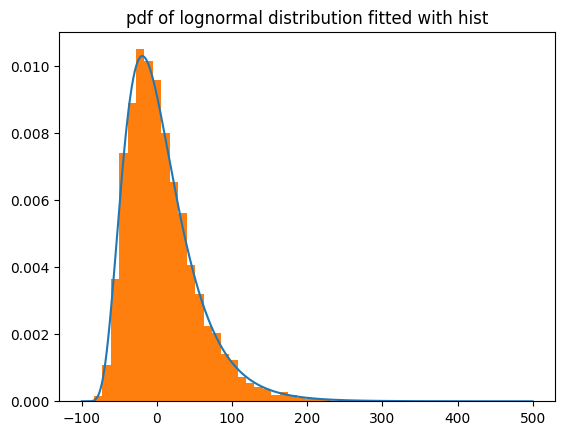

In [4]:
lognorm_x = S_0 * np.linspace(0, 6, 10000) - strike
lognorm_y = (
    sps.lognorm.pdf(
        x=np.linspace(0, 6, 10000),
        loc=(rf - sigma**2 / 2) * ttm,
        s=sigma * np.sqrt(ttm),
        scale=1,
    )
    / S_0
)
nBins = int(np.min([np.sqrt(x.size), 40]))

plt.plot(lognorm_x, lognorm_y)
plt.hist(x, bins=nBins, density=True)

plt.title("pdf of lognormal distribution fitted with hist")
plt.show()

#### The importance of initialize seed

Random number generation in programming is based on a formula that uses a seed and a state. A seed sets the generator to start from a specific state. After generating a random number, the generator transitions to another state. This process is known as pseudo-random number generation, where "pseudo" signifies "artificial".

Initializing the seed using `np.random.seed(xxx)`, where xxx can be any integer, is crucial for reproducibility in Monte Carlo simulations. This ensures the same sequence of random numbers is generated for the same seed, leading to consistent results across multiple runs.


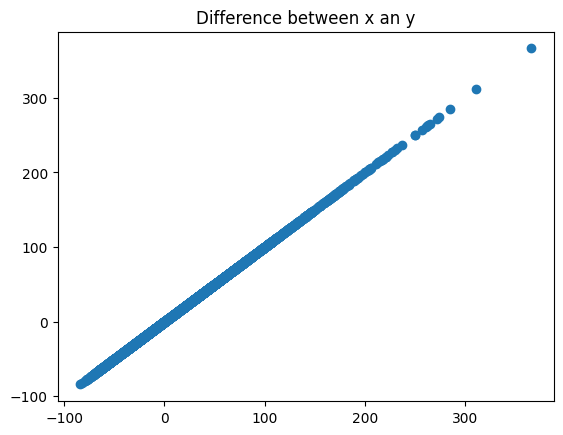

In [5]:
# Because we initialized the random number generator with the same seed
# before we call npr.normal and npr.lognormal, the two arrays x and y are the same.
# So the scatter plot of both arrays should be a straight line.

plt.scatter(x, y)
plt.title("Difference between x an y")
plt.show()

#### Multiple-steps Simulation

In many simulations, especially in financial modeling like Monte Carlo simulations, we often need to simulate the process over multiple steps or time periods. This is particularly important for path-dependent options, where the payoff depends on the sequence of prices, not just the final price.

For multiple steps, we generate a sequence of random numbers and apply the formula at each step. The asset price at each step depends on the price at the previous step.

If we would like to parallelize the simulation, it can only be done at the path level, not at the step level.


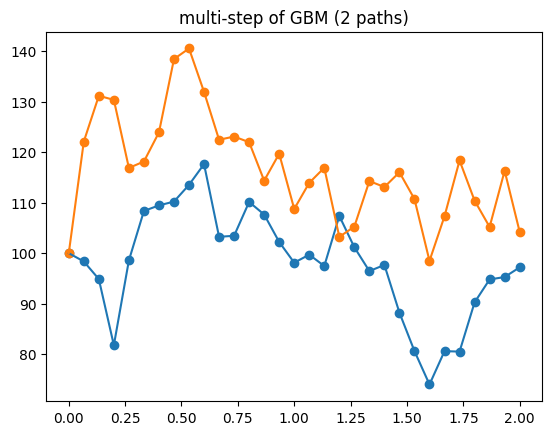

138 µs ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
def option_payoff(S_0, strike, ttm, rf, sigma, payoff_func, z):
    S = gbm(S_0, ttm, rf, sigma, z)
    return payoff_func(S, strike)


def gbm_path(S_0, ttm, rf, sigma, N):
    delta_t = ttm / N
    z = npr.normal(size=N)

    # Implementation #1
    # We use a for loop to calculate the path of the GBM step by step.
    S1 = np.zeros(N + 1)
    S1[0] = S_0
    for i in range(1, N + 1):
        S1[i] = gbm(S1[i - 1], rf, sigma, delta_t, z[i - 1])

    # Implementation #2 (faster)
    # We transform the exponential terms from multiplication to sum.
    # e(x)*e(y) = e(x+y)
    S2 = np.zeros(N + 1)
    S2[0] = S_0
    S2[1:] = (rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z
    S2[1:] = np.cumsum(S2[1:])
    S2[1:] = S_0 * np.exp(S2[1:])
    # print(S)

    # Implementation #1 is equivalent to #2
    assert np.allclose(S1, S2)

    # We will use #2
    return S2


# test two implementation. No assertion error, as expected.
x, y = np.linspace(0, ttm, 30 + 1), gbm_path(S_0, ttm, rf, sigma, 30)
plt.plot(x, y)
plt.scatter(x, y)

# generate another path
x, y = np.linspace(0, ttm, 30 + 1), gbm_path(S_0, ttm, rf, sigma, 30)
plt.plot(x, y)
plt.scatter(x, y)

plt.title("multi-step of GBM (2 paths)")
plt.show()

%timeit gbm_path(S_0,ttm,rf,sigma,30)

In [8]:
npr.normal(size=10)

array([ 1.73905643e-01, -1.30088735e+00, -1.14978295e+00, -1.09362578e+00,
        1.11618020e+00, -1.17020045e-03,  1.48746428e+00,  6.47328378e-01,
        7.77499894e-02,  2.70504000e-01])

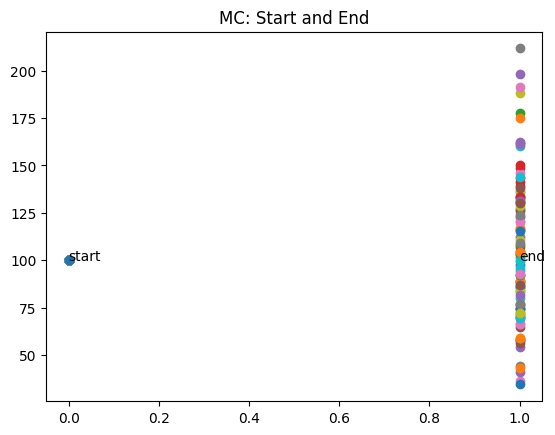

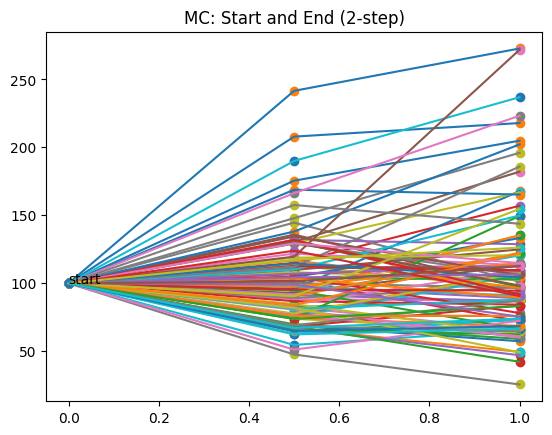

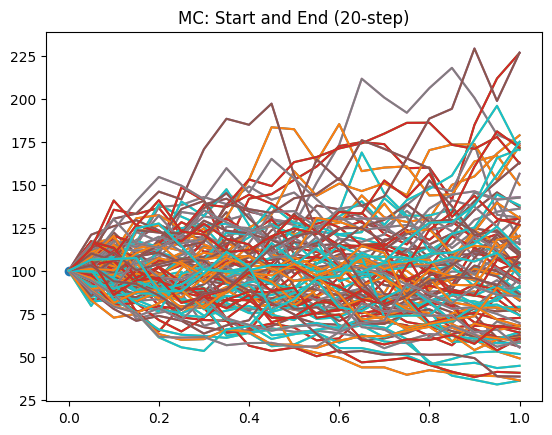

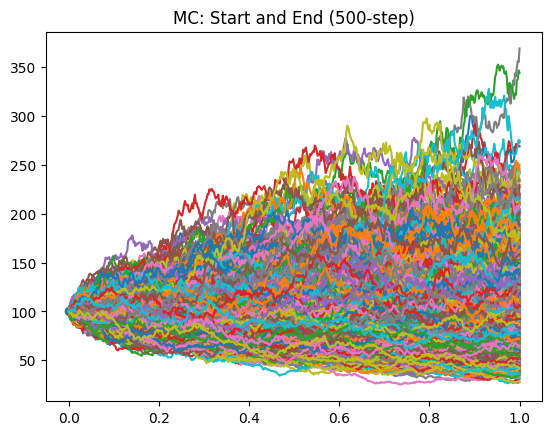

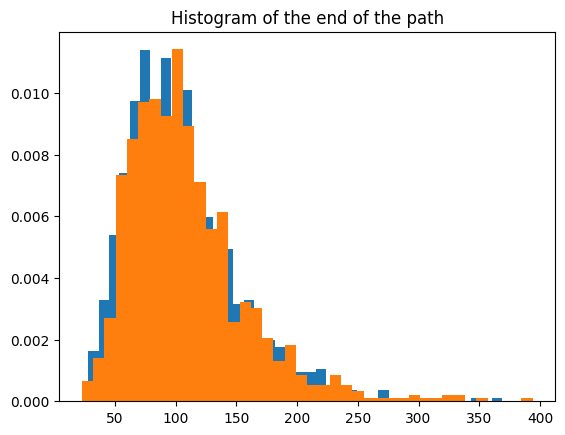

In [7]:
# The gbm_path function of the #2 implementation.


def gbm_path(S_0, ttm, rf, sigma, N):
    z = npr.normal(size=N)
    delta_t = ttm / N
    S = np.zeros(N + 1)
    S[0] = S_0
    S[1:] = S_0 * np.exp(
        np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z)
    )
    return S


plt.title("MC: Start and End")
plt.scatter(0, S_0)
plt.text(0, S_0, "start")
for i in range(100):
    p = gbm_path(S_0, ttm, rf, sigma, 1)
    plt.scatter(np.linspace(0, 1, 2), p)
plt.text(1, S_0, "end")
plt.show()

plt.title("MC: Start and End (2-step)")
plt.scatter(0, S_0)
plt.text(0, S_0, "start")
for i in range(100):
    p = gbm_path(S_0, ttm, rf, sigma, 2)
    plt.plot(np.linspace(0, 1, 3), p)
    plt.scatter(np.linspace(0, 1, 3), p)
plt.show()

plt.title("MC: Start and End (20-step)")
plt.scatter(0, S_0)
for i in range(100):
    p = gbm_path(S_0, ttm, rf, sigma, 20)
    plt.plot(np.linspace(0, 1, 21), p)
    plt.plot(np.linspace(0, 1, 21), p)
plt.show()

last_s = np.zeros(1000)
plt.title("MC: Start and End (500-step)")
plt.scatter(0, S_0)
for i in range(1000):
    p = gbm_path(S_0, ttm, rf, sigma, 500)
    last_s[i] = p[-1]
    plt.plot(np.linspace(0, 1, 501), p)
plt.show()

plt.title("Histogram of the end of the path")
plt.hist(last_s, bins=40, density=True, label="MC")

y = S_0 * npr.lognormal(rf - sigma**2 / 2, sigma * np.sqrt(ttm), size=1000)
plt.hist(y, bins=nBins, density=True, label="lognormal")
plt.show()

#### Code Optimization for Monte Carlo Loop

Let's consider a few path-dependent option types and how we can write optimized code to implement the Monte Carlo simulation for them.

-   **Asian Option**: Specifically, we're looking at an _arithmetic_ Asian call option, where the payoff is the average of all the prices on the path.

$$
\text{Payoff} = \frac 1 n \sum_1^n S_{n}
$$

In the example below, the option is monthly for 2 years.

-   **Lookback, Fixed Strike**: The payoff is the maximum price over the path.

$$
\text{Payoff} =  \max{(S_n)}
$$

We can optimize the Monte Carlo loop by reusing the simulated path for all options. This allows the computational cost to be shared across multiple instruments.


In [10]:
# arithmetic asian option call for the average of all the prices
# on the path.
# calculate the average of Asian Payoff.
ttm = 2
S_0 = 100
strike = 100
sigma = 0.3
rf = 0.02
N = 24
M = 100000

In [12]:
zs

array([[-1.0856306 ,  0.99734545,  0.2829785 , ...,  1.49073203,
        -0.93583387,  1.17582904],
       [-1.25388067, -0.6377515 ,  0.9071052 , ..., -0.01183049,
         2.39236527,  0.41291216],
       [ 0.97873601,  2.23814334, -1.29408532, ...,  0.19952407,
         0.46843912, -0.83115498],
       ...,
       [ 1.78247492,  0.24753728,  0.64554293, ..., -0.8057658 ,
        -0.43720926, -0.80892213],
       [-0.1786086 ,  1.32706964, -1.54274277, ..., -0.66101577,
        -0.01353771,  1.02507785],
       [ 0.30581648, -1.23948992,  2.41247052, ...,  0.61805477,
        -0.17164406, -0.35261308]])

In [11]:
def gbm_path_z(S_0, a, b, z):
    zs = np.cumsum(a + b * z)
    S = S_0 * np.exp(zs)
    return S


def pay_off_asian_call(S_arr, strike, step):
    return np.maximum(np.mean(S_arr[::step]) - strike, 0)


def pay_off_european_call(S_arr, strike, _step):
    return np.maximum(S_arr[-1] - strike, 0)


def pay_off_lookback_call(S_arr, strike, _step):
    return np.maximum(S_arr.max() - strike, 0)


npr.seed(123)
step = N // 24
assert N % 24 == 0

zs = npr.normal(size=(M, N))
delta_t = ttm / N
loc = (rf - 0.5 * sigma**2) * delta_t
scale = sigma * np.sqrt(delta_t)

all_po_asian = np.zeros(M)
all_po_european = np.zeros(M)
all_po_lookback = np.zeros(M)
for m in range(M):
    # We re-use the same gbm paths for different options' calculation
    # MC is free to do any payoff
    gbm_paths = gbm_path_z(S_0, loc, scale, zs[m])
    all_po_asian[m] = pay_off_asian_call(gbm_paths, strike, step)
    all_po_european[m] = pay_off_european_call(gbm_paths, strike, step)
    all_po_lookback[m] = pay_off_lookback_call(gbm_paths, strike, step)

display(
    (
        "european",
        np.exp(-rf * ttm) * all_po_european.mean(),
        all_po_european.std() / np.sqrt(M),
    )
)  # this measure is the standard error for MC, to be explained in the next section

display(
    ("asian", np.exp(-rf * ttm) * all_po_asian.mean(), all_po_asian.std() / np.sqrt(M))
)

display(
    (
        "lookback",
        np.exp(-rf * ttm) * all_po_lookback.mean(),
        all_po_lookback.std() / np.sqrt(M),
    )
)

('european', 18.636044456120736, 0.11012229181355283)

('asian', 10.871569071390597, 0.05985357006628045)

('lookback', 33.693582345564856, 0.1218423262652483)

In [16]:
N

24

The code below plots the running average of the simulated asset price. The running average is the average of the first $n$ prices, where $n$ is the number of steps in the simulation.

This is useful for understanding the convergence of the simulation.


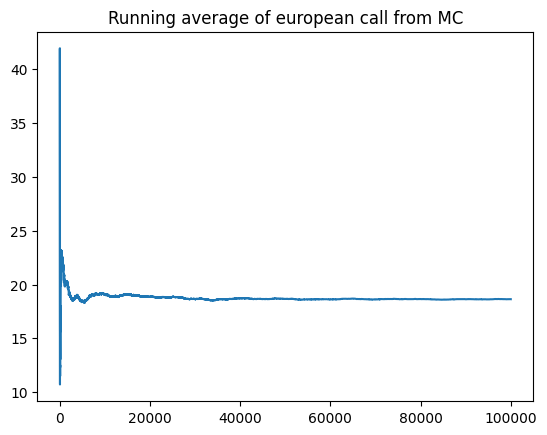

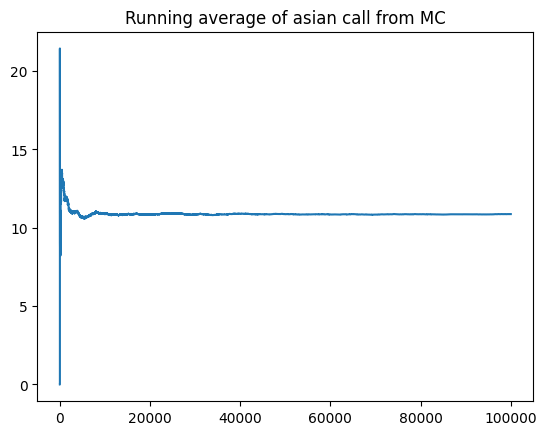

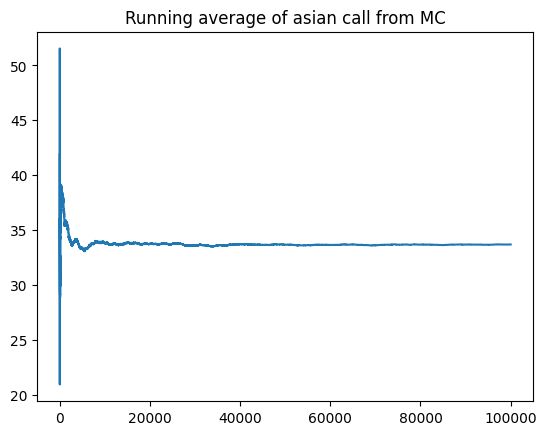

In [10]:
plt.plot(
    np.arange(1, M + 1),
    (np.exp(-rf * ttm) * all_po_european.cumsum()) / np.arange(1, M + 1),
)
plt.title("Running average of european call from MC")
plt.show()

plt.plot(
    np.arange(1, M + 1),
    (np.exp(-rf * ttm) * all_po_asian.cumsum()) / np.arange(1, M + 1),
)
plt.title("Running average of asian call from MC")
plt.show()

plt.plot(
    np.arange(1, M + 1),
    (np.exp(-rf * ttm) * all_po_lookback.cumsum()) / np.arange(1, M + 1),
)
plt.title("Running average of asian call from MC")
plt.show()

### Accuracy of Monte Carlo Simulations

In Monte Carlo (MC) simulations, the mean from the simulation trials, $\bar{y} = \text{Average}(\text{Payoff}(z))$, serves as an estimate for the value of the derivative, $\mu_y = \mathbb{E}(\text{Payoff}(z))$. The accuracy of this estimate is measured by the difference between $\bar{y}$ and $\mu_y$.

$$E(\bar{y} - \mu _ y)= E(\bar{y}) - \mu _ y \\ =E\left(\frac{1}{N}\sum \limits _{i=1}^{N} y_ i \right) - \mu _ y \\ =\frac{1}{N}\sum \limits _{i=1}^{N} E(y_ i) - \mu _ y$$

$E(y_i)=\mu_y$ when the $y_ i$'s occurrence from a large random sampling of the inputs when using the Monte Carlo method. Thus we have:

$$E(\bar{y} - \mu _ y) = \frac{1}{N} N \mu _ y - \mu _ y = 0$$

The expectation of this difference, $E(\bar{y} - \mu _ y)$, is zero, indicating that the error in using $\bar{y}$ to approximate $\mu _ y$ is zero. This means that the MC result is an unbiased estimator for the true result.

Next, to estimate the variance for $\bar{y}-\mu_y$, noting that the variance of $\mu _ y$ is zero as it is a constant:

$$
V(\bar{y} - \mu _ y) = V(\bar{y}) - V(\mu _ y) \\
 = V(\bar{y})
$$

Because the Monte Carlo method draws independent, random samples, the variance of the sum of the samples $y_ i$ is the sum of their variances. Therefore, we have,

$$
V(\bar{y}) = \\
 = V\left(\frac{\sum \limits _{i=1}^{N} y_ i}{N}\right) \\
 = \frac{1}{N^2}V\left(\sum \limits _{i=1}^{N} y_ i\right) \\
 = \frac{1}{N^2}\sum \limits _{i=1}^{N} V(y_ i) \\
 = \frac{1}{N^2} N \sigma _ y^{2} \\
 = \frac{\sigma _ y^{2}}{N}
$$

The variance for $V(\bar{y} - \mu_y)$, is $\frac{\sigma_y^{2}}{N}$, where $\sigma_y^{2}$ is the variance of $y$ and $N$ is the number of trials. This shows that the standard error decreases with the square root of the sample size, $\sqrt {N}$.

To reduce the variability in the mean estimate by a factor of 10, the number of MC trials must be increased by a factor of 100.

The normalized standard deviation, $\frac{\sigma _ y}{\sqrt{N}}$, is used as a measure for the accuracy of the MC result. The complete MC result, including the accuracy measure, is written as $\bar{y} \pm \frac{\sigma _ y}{\sqrt{N}}$.


#### Impact of Paths and Time Steps on Monte Carlo Simulations

In Monte Carlo simulations, the accuracy of the result is influenced by the number of paths and the granularity of time steps.

As the number of paths increases or the time steps become finer, the absolute difference between the Monte Carlo simulation result and the Black-Scholes price tends to decrease. This implies that a larger number of paths and finer time steps can lead to more accurate simulations.

Below demo code compares the impact of the number of paths `M` and the granularity of time steps `N` on the accuracy of the Monte Carlo simulation for GBM.

-   When we are using the exact integration for the Black-Scholes model. We can use 1 time step for path-independent options. The standard deviation of the result is primarily affected by the number of paths, not the granularity of the time steps.

-   We we using the other stochastic models, we need to use multiple time steps to achieve acceptable level of accuracy in path generation. Afterwards, we can increase the number of paths to reduce the standard deviation of the result.


In [11]:
S_0 = 100
strike = 100
ttm = 2
rf = 0.03
sigma = 0.3


def bs_call(S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    return S * sps.norm.cdf(d1) - strike * np.exp(-rf * ttm) * sps.norm.cdf(d2)


def bs_put(S, strike, ttm, rf, sigma):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    return sps.norm.cdf(-d2) * strike * np.exp(-rf * ttm) - sps.norm.cdf(-d1) * S


c = bs_call(S_0, strike, ttm, rf, sigma)
p = bs_put(S_0, strike, ttm, rf, sigma)


def gbm_path(S_0, ttm, rf, sigma, N):
    delta_t = ttm / N
    z = npr.normal(size=N)
    zs = np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z)
    S = S_0 * np.exp(zs)
    return S


def call_payoff(S_arr, strike):
    return np.maximum(S_arr[-1] - strike, 0)


def put_payoff(S_arr, strike):
    return np.maximum(strike - S_arr[-1], 0)


def asian_call_payoff(S_arr, strike):
    return np.maximum(S_arr.mean() - strike, 0)


def option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N):
    S = gbm_path(S_0, ttm, rf, sigma, N)
    return payoff_func(S, strike)


def mc_pricer(S_0, strike, ttm, rf, sigma, payoff_func, N, M):
    payoff = np.zeros(M)
    for i in range(M):
        payoff[i] = option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N)
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoff)
    mc_stdev = df * np.std(payoff) / np.sqrt(M)
    return mc_pv, mc_stdev


for N in [int(1), int(100), int(1000)]:
    first_time = True
    value_to_compare = p
    for M in np.power(10, np.array([1, 2, 3, 4, 5, 6])):
        M = int(M)
        # mc_c,mc_stdev=mc_pricer(S_0,strike,ttm,rf,sigma,call_payoff,N,M)
        # mc_c,mc_stdev=mc_pricer(S_0,strike,ttm,rf,sigma,put_payoff,N,M)
        mc_c, mc_stdev = mc_pricer(S_0, strike, ttm, rf, sigma, asian_call_payoff, N, M)
        if first_time:
            print(
                f"mc @ M={M:6d} N={N:3d}: result={mc_c:5.2f}, diff={np.abs(mc_c-value_to_compare):5.2f}, stdev={mc_stdev:5.2f}"
            )
            first_time = False
        else:
            print(
                f"mc @ M={M:6d} N={N:3d}: result={mc_c:5.2f}, diff={np.abs(mc_c-value_to_compare):5.2f}, stdev={mc_stdev:5.2f}, "
                f"ratio between stdev={mc_stdev/mc_stdev_p:5.2f} ~ ratio of iteration {np.sqrt(M_p)/np.sqrt(M):4.2f}"
            )
        M_p, mc_c_p, mc_stdev_p = M, mc_c, mc_stdev

mc @ M=    10 N=  1: result= 9.69, diff= 3.86, stdev= 5.17
mc @ M=   100 N=  1: result=22.84, diff= 9.28, stdev= 3.40, ratio between stdev= 0.66 ~ ratio of iteration 0.32
mc @ M=  1000 N=  1: result=18.96, diff= 5.40, stdev= 1.07, ratio between stdev= 0.32 ~ ratio of iteration 0.32
mc @ M= 10000 N=  1: result=19.41, diff= 5.86, stdev= 0.34, ratio between stdev= 0.32 ~ ratio of iteration 0.32
mc @ M=100000 N=  1: result=19.35, diff= 5.79, stdev= 0.11, ratio between stdev= 0.31 ~ ratio of iteration 0.32
mc @ M=1000000 N=  1: result=19.42, diff= 5.86, stdev= 0.03, ratio between stdev= 0.32 ~ ratio of iteration 0.32
mc @ M=    10 N=100: result=18.72, diff= 5.16, stdev= 6.63
mc @ M=   100 N=100: result= 6.83, diff= 6.72, stdev= 1.16, ratio between stdev= 0.17 ~ ratio of iteration 0.32
mc @ M=  1000 N=100: result=10.32, diff= 3.24, stdev= 0.56, ratio between stdev= 0.48 ~ ratio of iteration 0.32
mc @ M= 10000 N=100: result=11.24, diff= 2.32, stdev= 0.18, ratio between stdev= 0.32 ~ ratio of 

#### Confidence Bounds in Option Pricing with Monte Carlo Simulations

In Monte Carlo simulations for option pricing, a confidence bound can be established around the calculated option price. This bound is typically determined by the number of simulation paths (N), and the mean ($\mu$) and variance ($\sigma^2$) of the payoffs for all generated paths.

For options where the underlying asset is assumed to follow a log-normal distribution (as per the stock price evolution equation for equities), a 95% confidence bound can be placed on the resulting option price. This is represented as:

$$
\hat{\mu} - \frac {1.96 \hat{\sigma}} {\sqrt{N}} < Option Price < \hat{\mu} + \frac {1.96 \hat{\sigma}} {\sqrt{N}}
$$

Here, $\hat{\mu}$ is the estimated mean of the payoffs and $\hat{\sigma}$ is the estimated standard deviation of the payoffs. The factor of 1.96 corresponds to the 95% confidence level in a standard normal distribution.


#### Discussion and Key Points on Monte Carlo Simulations in Option Pricing

#### Discussion Points:

-   **Option Pricing**: The price of an option can be estimated using Monte Carlo simulations by generating multiple paths for the underlying asset's price and calculating the payoff for each path. The average payoff across all paths is the estimated option price.

-   **Asian Options**: Monte Carlo simulations can handle Asian options, which are path-dependent, as they can simulate the underlying asset price path by path.

-   **Finite Difference vs Monte Carlo for Exotic Options**: The speed of pricing exotic options like binary knockouts depends on the specifics of the option and the computational resources available. Generally, Monte Carlo simulations can be slower due to the large number of paths required.

-   **Finite Difference vs Monte Carlo for Basket Options**: Similar to exotic options, the speed of pricing basket options depends on the specifics of the option and the computational resources. Monte Carlo simulations can handle high-dimensional problems better, making them potentially more suitable for basket options.

-   **Random $\sigma$ and $\mu$**: If either $\sigma$ or $\mu$ follow a random process, i.e. stochastic volatility, stochastic interest rate, Monte Carlo simulation is easier to implement.

#### Key Points:

-   Monte Carlo simulations can be used to price options with complex payoffs, such as Asian options, lookback options, and basket options by simulating the underlying asset price path by path and calculating the associated payoff for each simulated path.

-   Monte Carlo simulations is also good to handle high-dimension problems, such as basket options.

-   Pricing American options / Bermuda options present a challenge to Monte Carlo method due to the difficulty in estimating the holding value at any time point based on a single subsequent path.

-   There are various schemes exist to discretize the stochastic process in Monte Carlo simulations, such as the Euler Scheme, Milstein, and Euler-Richardson extension. Different process needs to work with specific scheme to minimize the error (i.e. truncation error of representing the continuous process with discrete steps).

The choice of scheme often requires experimentation to determine which performs better for a given payoff function and/or Stochastic Differential Equation (SDE) $X_t$.


### 1.3 Exercise

We'll price Lookback options for both fixed and floating call and put options. The results will include the standard deviation.

Lookback options are path-dependent options where the payoff depends on the maximum or minimum asset price during the life of the option. The payoff for Lookback options is calculated as follows:

-   Fixed Strike Lookback Call (LC\*fixed): $\max(0, S_{max}-K)$
-   Fixed Strike Lookback Put (LP\*fixed): $\max(0, K-S_{min})$
-   Floating Strike Lookback Call (LC\*floating): $\max(0, S-S_{min})$
-   Floating Strike Lookback Put (LP\*floating): $\max(0, S_{max}-S)$

Where:

-   $S_{max}$ is the maximum asset price during the life of the option
-   $S_{min}$ is the minimum asset price during the life of the option
-   $K$ is the strike price
-   $S$ is the asset price at maturity

| Input          | Value  |
| -------------- | ------ |
| Spot           | 100    |
| Year fraction  | 1/252  |
| Sigma          | 30%    |
| Strike         | 110    |
| Risk free rate | 2%     |
| Maturity       | 1 year |


In [30]:
S_0 = 100
strike = 110
ttm = 1
rf = 0.02
sigma = 0.3
N = 252
M = 10000

def gbm_path(S_0, ttm, rf, sigma, N):
    delta_t = ttm / N
    z = npr.normal(size=N)
    zs = np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z)
    S = S_0 * np.exp(zs)
    return S


def pay_off_lookback_call(S_arr, strike):
    return np.maximum(S_arr.max() - strike, 0)

def pay_off_lookback_put(S_arr, strike):
    return np.maximum(strike - S_arr.min(), 0)

def pay_off_lookback_call_float(S_arr, strike):
    return np.maximum(S_arr[-1] - S_arr.min(), 0)

def pay_off_lookback_put_float(S_arr, strike):
    return np.maximum(S_arr.max() - S_arr[-1], 0)

def option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N):
    S = gbm_path(S_0, ttm, rf, sigma, N)
    return payoff_func(S, strike)

def mc_pricer(S_0, strike, ttm, rf, sigma, payoff_func, N, M):
    payoff = np.zeros(M)
    for i in range(M):
        payoff[i] = option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N)
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoff)
    mc_stdev = df * np.std(payoff) / np.sqrt(M)
    return mc_pv, mc_stdev

npr.seed(123)


# zs = npr.normal(size=(M, N))
# delta_t = ttm / N
# loc = (rf - 0.5 * sigma**2) * delta_t
# scale = sigma * np.sqrt(delta_t)


fixed_strike_lookback_call_price, fixed_strike_lookback_call_std = mc_pricer(S_0, strike, ttm, rf, sigma, pay_off_lookback_call, N, M)
fixed_strike_lookback_put_price, fixed_strike_lookback_put_std = mc_pricer(S_0, strike, ttm, rf, sigma, pay_off_lookback_put, N, M)

float_strike_lookback_call_price, float_strike_lookback_call_std = mc_pricer(S_0, strike, ttm, rf, sigma, pay_off_lookback_call_float, N, M)
float_strike_lookback_put_price, float_strike_lookback_put_std = mc_pricer(S_0, strike, ttm, rf, sigma, pay_off_lookback_put_float, N, M)

print(f"fixed_strike_lookback_call_price = {fixed_strike_lookback_call_price:.2f}, fixed_strike_lookback_call_std = {fixed_strike_lookback_call_std:.2f}")
print(f"fixed_strike_lookback_put_price = {fixed_strike_lookback_put_price:.2f}, fixed_strike_lookback_put_std = {fixed_strike_lookback_put_std:.2f}")

print(f"float_strike_lookback_call_price = {float_strike_lookback_call_price:.2f}, float_strike_lookback_call_std = {float_strike_lookback_call_std:.2f}")
print(f"float_strike_lookback_put_price = {float_strike_lookback_put_price:.2f}, float_strike_lookback_put_std = {float_strike_lookback_put_std:.2f}")

fixed_strike_lookback_call_price = 18.01, fixed_strike_lookback_call_std = 0.23
fixed_strike_lookback_put_price = 29.36, fixed_strike_lookback_put_std = 0.13
float_strike_lookback_call_price = 21.46, float_strike_lookback_call_std = 0.22
float_strike_lookback_put_price = 23.45, float_strike_lookback_put_std = 0.15


### 1.4 Discretize for Non-GBM Stochastic Movement (Optional)

The Euler-Maruyama method is a numerical method used to approximate solutions to Stochastic Differential Equations (SDEs). It's particularly useful for non-Geometric Brownian Motion (GBM) stochastic movements.

A generic Itô-Diffusion SDE

$$
\begin{aligned}
dX_t &= \mu(t,X_t) dt + \sigma(t, X_t) dW_t \\
X_0 &= 0 \\
\end{aligned}
$$

Can be approximated by the Euler-Maruyama method as:

$$
\begin{aligned}
X\_{i+1} &= X_i + \mu(t_i,X_i) \Delta t + \sigma(t_i, X_i) \Delta W_i \\
X_0 &= 0 \\
\end{aligned}
$$

Where $X(t_i) = X_i$ and $W(t_i) = W_i$, and $\Delta W_i \sim \mathcal{N}(0, \sqrt{\Delta t})$.


#### Example: Cox-Ingersoll-Ross (CIR) Model

The CIR model for interest rate is given by:

$$
dr_{t}=\kappa(\theta-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dW_{t}
$$

Applying the Euler-Maruyama method to the CIR SDE, we get:

$$X\_{i+1} = X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{X_i} \Delta W_i $$

However, when discretizing the process, $X_i$ can become negative, which is problematic for an interest rate model. Two common methods to overcome this problem are:

1. $$
   X_{i+1} = X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{|X_i|} \Delta W_i
   $$

2. $$
   X_{i+1} = |X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{X_i} \Delta W_i |
   $$

Method 1) resolves the square root problem, but the process can still become negative. Method 2) prevents this possibility. A better way to prevent this happening is to adopt the Milstein scheme.


#### Milstein scheme

The Milstein scheme improves upon the Euler-Maruyama method by adding a second-order correction term. For the Black-Scholes model, the correction term is $\frac 1 2 \sigma ^ 2 dt (Z^2 - 1)$.

$$
S_{t+dt} = S_t + r S_t dt + \sigma \sqrt {dt} Z + \frac 1 2 \sigma ^ 2 dt (Z^2 - 1)
$$

The Milstein scheme improves the discretization of $S_t$ in the Black-Scholes model, but it does not improve the discretization of $ln{S_t}$. Therefore, while the Euler scheme for log-stock is often used for Black-Scholes model discretization, the Milstein scheme is preferred for other models that may have numerical problems.

Example:

The variance process in Heston model

$$
v = −\lambda (v − \bar v) dt + \eta \sqrt {v} dZ^2
$$

Euler discretization is

$$
v_{i+1} = v_i − \lambda (v_i − \bar v) \Delta t + \eta \sqrt {v_i} \sqrt {\Delta t} Z
$$

with $Z ∼ N(0, 1)$ may give rise to a negative variance.

However, Milstein scheme is preferred.

$$
v_{i+1} = (\sqrt {v_i} + \frac \eta 2 \sqrt {\Delta t} Z)^2 - \lambda (v_i - \bar v) \Delta t - \frac {\eta^2} 4 \Delta t
$$

We note that if $v_i = 0$ and $4 \lambda \bar v / \mu^2 > 1$, $v_{i+1} > 0$ indicating that frequency of occurrence of negative variances should be substantially reduced.

#### Exercise

Test Euler-Maruyama method for GBM can produce a lognormal distribution for prices at $T$ and $\frac T 2$.


## 2. Multi-asset MC with GBM

In multi-asset Monte Carlo simulations, we need to generate asset price paths that reflect the correlation between the assets. This requires generating correlated random numbers, $z_{n}$.

$$
{S_{n,i+1}} = {S_{n,i}} e ^ {(\mu -\frac{\sigma ^2}{2})dt+\sigma \sqrt{\Delta t} z_{n}}
$$

The correlation between assets is an important factor in pricing multi-asset options, portfolio risk management, and other financial applications.

To generate correlated random numbers, we can use the Cholesky decomposition of the correlation matrix.

### 2.1 Method 1: Use Cholesky decomposition

The Cholesky decomposition is a decomposition of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose.

-   Requirement for Cholesky decomposition
    -   Every correlation M/VCV matrix shall be **positive semi-definite**
    -   Determinant of M shall be strictly to $|M| > 0$
    -   Cholesky matrix should exist

$$
M = \begin{pmatrix}
1 & rho \\
rho & 1
\end{pmatrix}
$$

Cholesky decomposition (Lower triangular matrix)

$$
A = \begin{pmatrix}
1 & 0 \\
rho & \sqrt{1-rho^2})
\end{pmatrix}
$$

Satisfying

$$
A \cdot A^T = M
$$

$\varepsilon_{i}$ are uncorrelated random numbers and $z_{i}$ are correlated.

$$
Z = A \varepsilon
$$


### 2.2 Method 2: Eigenvector/Eigenvalue

Eigenvector/Eigenvalue decomposition is a powerful tool in linear algebra. It involves decomposing a matrix into its constituent parts to reveal certain properties of the matrix that are not immediately apparent.

In Germany, eigen means "own" or "characteristic".

For a given matrix $M$, the eigenvalues ($\lambda$) and eigenvectors ($X$) satisfy the following equation:

$$
M X = \lambda X
$$

In this equation, $X$ is an eigenvector of $M$ and $\lambda$ is the corresponding eigenvalue. Each eigenvalue-eigenvector pair satisfies this equation.

Eigenvector/Eigenvalue decomposition allows us to express a matrix $M$ as the product of a matrix of its eigenvectors ($Q$), a diagonal matrix of its eigenvalues ($\Lambda$), and the inverse of the matrix of its eigenvectors ($Q^{-1}$):

$$
M = Q \Lambda Q^{-1}
$$

Each column of $Q$ is an eigenvector of $M$, and the corresponding entry on the diagonal of $\Lambda$ is the associated eigenvalue.

The correlated random variable $Z$ can be expressed as:

$$
Z = Q' \Lambda z
$$

Here, $Q'$ is $Q$ normalized to unit length. For a 2x2 matrix $Q$, the normalization process is as follows:

$$
Q = \begin{pmatrix}
 v^\prime_{11} & v^\prime_{12} \\
 v^\prime_{21} & v^\prime_{22}
\end{pmatrix}
=
\begin{pmatrix}
v_{11} \over {\sqrt{(v_{11}^2 + v_{21}^2)}} & v_{12} \over \sqrt{(v_{12}^2 + v_{22}^2)} \\
v_{21} \over {\sqrt{(v_{11}^2 + v_{21}^2)}}& v_{22} \over \sqrt{(v_{12}^2 + v_{22}^2)} \\
\end{pmatrix}
$$

When full substituted, the correlated random variables $Z_1$ and $Z_2$ can be expressed as a transformation of the uncorrelated random variables $z_1$ and $z_2$:

$$
\begin{pmatrix}
 Z_1 \\
 Z_2
\end{pmatrix}
=
\begin{pmatrix}
 v^\prime_{11} & v^\prime_{12} \\
 v^\prime_{21} & v^\prime_{22}
\end{pmatrix}
\begin{pmatrix}
 \sqrt {\lambda_1} & 0 \\
 0 & \sqrt {\lambda_2}
\end{pmatrix}
\begin{pmatrix}
 z_1 \\
 z_2
\end{pmatrix}
$$


### 2.3 Example for Generating Correlated Random Numbers

We use `np.corrcoef` to verify the correlation from the generated random numbers.

#### 2.3.1 Cholesky Decomposition


In [31]:
# With Cholesky Decomposition

rho = 0.65
corr = np.array([[1, rho], [rho, 1]])
print(f"Input correlation matrix: \n{corr}\n")

chol = np.linalg.cholesky(corr)
print(
    "chol:\n",
    chol,
    "\n",
    "Verify chol to restore corr = chol * chol.T:\n",
    np.matmul(chol, chol.T),
    "\n",
    "Equal to corr:",
    np.allclose(np.matmul(chol, chol.T), corr),
)

z = np.matmul(chol, npr.normal(size=(2, 100000)))
print(f"{z.shape=}")
print("z is with correlation of:")
print(np.corrcoef(z[0, :], z[1, :]))

Input correlation matrix: 
[[1.   0.65]
 [0.65 1.  ]]

chol:
 [[1.         0.        ]
 [0.65       0.75993421]] 
 Verify chol to restore corr = chol * chol.T:
 [[1.   0.65]
 [0.65 1.  ]] 
 Equal to corr: True
z.shape=(2, 100000)
z is with correlation of:
[[1.         0.65158964]
 [0.65158964 1.        ]]


#### 2.3.2 Eigen Decomposition


In [32]:
from numpy import linalg as npla

rho12 = 0.65
corr = np.array([[1, rho12], [rho12, 1]])

# eig returns eigenvalues `v`` and "normalized" eigenmatrix `w``
w, v = npla.eig(corr)

display(np.matmul(np.matmul(v, np.diag(w)), npla.inv(v)))

display(
    np.matmul(
        np.matmul(v, np.sqrt(np.diag(w))), np.matmul(np.sqrt(np.diag(w)), npla.inv(v))
    )
)

L = np.matmul(v, np.sqrt(np.diag(w)))

z = np.matmul(L, npr.normal(size=(2, 100000)))
print("Correlated z with correlation of:")
print(np.corrcoef(z[0, :], z[1, :]))

array([[1.  , 0.65],
       [0.65, 1.  ]])

array([[1.  , 0.65],
       [0.65, 1.  ]])

Correlated z with correlation of:
[[1.         0.64994693]
 [0.64994693 1.        ]]


Choosing Cholesky or Eigenvalue/vector for decomposition depends on the specific requirements of the problem. Cholesky decomposition is generally faster and more stable, but it requires the matrix to be positive definite. Eigenvalue/vector decomposition is more general and can be used for any matrix, but it is slower and less stable.


#### 2.3.2 Use correlated random numbers in pricing

Let us the correlated random numbers in the MC simulation. We will first perform a test of the input correlation matrix and the return of generated price returns.


In [33]:
def gbm(S_0, rf, sigma, ttm, z):
    return S_0 * np.exp((rf - 0.5 * sigma**2) * ttm + sigma * np.sqrt(ttm) * z)


z = np.matmul(L, npr.normal(size=(2, 100000)))


sigma_0 = 0.3
sigma_1 = 0.5
S_0 = 100
S_1 = 100

p0 = gbm(S_0, rf, sigma_0, ttm, z[0, :])
p1 = gbm(S_1, rf, sigma_1, ttm, z[1, :])

# Calculate the correlation between the two price paths' return
print(np.corrcoef(p0 / S_0 - 1, p1 / S_1 - 1))

p0 = gbm(S_0, rf, sigma_0, ttm / 10, z[0, :])
p1 = gbm(S_1, rf, sigma_1, ttm / 10, z[1, :])

print(np.corrcoef(p0 / S_0 - 1, p1 / S_1 - 1))

p0 = gbm(S_0, rf, sigma_0, ttm / 100, z[0, :])
p1 = gbm(S_1, rf, sigma_1, ttm / 100, z[1, :])

print(np.corrcoef(p0 / S_0 - 1, p1 / S_1 - 1))

# When we take a very large time step, many prices will fell to zero
# It causes the correlation to be very low.
p0 = gbm(S_0, rf, sigma_0, ttm * 5, z[0, :])
p1 = gbm(S_1, rf, sigma_1, ttm * 5, z[1, :])
print(np.corrcoef(p0 / S_0 - 1, p1 / S_1 - 1))

p0 = gbm(S_0, rf, sigma_0, ttm * 100, z[0, :])
p1 = gbm(S_1, rf, sigma_1, ttm * 100, z[1, :])

print(np.corrcoef(p0 / S_0 - 1, p1 / S_1 - 1))

[[1.         0.62282685]
 [0.62282685 1.        ]]
[[1.         0.64497745]
 [0.64497745 1.        ]]
[[1.         0.64726422]
 [0.64726422 1.        ]]
[[1.         0.52256529]
 [0.52256529 1.        ]]
[[1.         0.14179326]
 [0.14179326 1.        ]]


The choice of time step size is crucial in Monte Carlo simulations. An appropriately sized time step ensures correct correlation and balances computational cost with simulation accuracy.

-   **Too small a time step** increases computational cost due to the larger number of calculations required.
-   **Too large a time step** reduces simulation accuracy as it may miss important fluctuations.

Here are some general guidelines for choosing a time step:

-   For maturities less than 1 year, a time step of 1/12 (one month) is often suitable.
-   For maturities greater than 1 year, a time step of 1/252 (1 business day) is commonly used. This is based on the convention that there are 252 trading days in a year.

In general, a time step of 1/252 is a good starting point for many scenarios. However, the optimal time step may vary depending on the specific requirements of your simulation. Always test different time steps to find the one that provides the best balance between accuracy and computational efficiency for your specific use case.


In [36]:
# Original correlation
print(np.corrcoef(100000 * z[1, :], 100000 * z[0, :]))

# Using delta_t = 1/252
delta_t = 1 / 252
p1 = S_0 * np.exp(
    np.cumsum((rf - 0.5 * sigma_0**2) * delta_t + sigma_0 * np.sqrt(delta_t) * z[0, :])
)
p2 = S_1 * np.exp(
    np.cumsum((rf - 0.5 * sigma_1**2) * delta_t + sigma_1 * np.sqrt(delta_t) * z[1, :])
)
print(np.corrcoef((p1[1:] / p1[:-1] - 1), (p2[1:] / p2[:-1] - 1)))

# Using delta_t = 10/252
delta_t = 10 / 252
p1 = S_0 * np.exp(
    np.cumsum((rf - 0.5 * sigma_0**2) * delta_t + sigma_0 * np.sqrt(delta_t) * z[0, :])
)
p2 = S_1 * np.exp(
    np.cumsum((rf - 0.5 * sigma_1**2) * delta_t + sigma_1 * np.sqrt(delta_t) * z[1, :])
)
print(np.corrcoef((p1[1:] / p1[:-1] - 1), (p2[1:] / p2[:-1] - 1)))

[[1.         0.64756224]
 [0.64756224 1.        ]]
[[1.         0.64741823]
 [0.64741823 1.        ]]
[[1.         0.64648254]
 [0.64648254 1.        ]]


### 2.3 Example: Basket option

A basket option is a type of financial derivative based on a weighted average of several underlying assets. For instance, an index fund, which is a portfolio of various assets, can be considered a basket. The price of the basket, $U(t)$, is the weighted average of the prices of the individual assets, $S_i$, with weights $a_i$:

$$U(t) = \sum_i a_i S_i(t) $$

A basket call option with strike price $K$ has a payoff of $\text{max}(U(T) - K, 0)$. When the basket is a simple portfolio, this is also known as a portfolio option.

In the Black-Scholes model, the assets in the portfolio are modeled by geometric Brownian motion. However, the sum of lognormal distributions is not lognormal, so each component of the portfolio must be modeled individually.

| Input                 | Value |
| --------------------- | ----- |
| Asset 1               | 45    |
| Asset 2               | 12    |
| Correlation           | 0.75  |
| Volatility of Asset 1 | 15%   |
| Volatility of Asset 2 | 22%   |
| Weight of Asset 1     | 1/3   |
| Weight of Asset 2     | 2/3   |
| risk free rate        | 2%    |
| Maturity              | 1     |
| Iterations            | 1000  |
| Strike                | 20    |


In [37]:
import numpy as np

rho = 0.75
corr = np.array([[1, rho], [rho, 1]])
chol = np.linalg.cholesky(corr)
print("chol:\n", chol, "\n", "Verify chol:\n", np.matmul(chol, chol.T), "\n")

asset1 = 45
asset2 = 12
sigma1 = 0.15
sigma2 = 0.22
strike = 20
w1 = 1 / 3
w2 = 2 / 3
w_a = np.array([w1, w2])
rf = 0.02

ttm = 1
year_frac = 1
dt = 1 / year_frac
sim_points = int(year_frac * ttm)
# sqrt_dt = np.sqrt(ttm / year_frac)
sqrt_dt = np.sqrt(dt)

S_0 = np.array([asset1, asset2]).reshape(2, 1)
sigma_a = np.array([sigma1, sigma2]).reshape(2, 1)

# Set the seed for reproducibility
rng_1 = np.random.default_rng(42012133132132141241231982387525)
# rng_1 = np.random.default_rng()
last_index = sim_points - 1

print("init value: ", S_0[:, 0].dot(w_a) - strike)


def basket(display_corr=False):
    variates = rng_1.normal(size=(2, sim_points))
    corr_variates = np.matmul(chol, variates)
    if year_frac > 1 and display_corr:
        print("correl:\n", np.corrcoef(corr_variates[0, :], corr_variates[1, :]))
    # print(corr_variates.shape)
    # I am breaking the long line into shorter lines
    xv = (rf - 0.5 * sigma_a**2) * dt + sigma_a * np.sqrt(dt) * corr_variates
    S_t = S_0 * np.exp(np.cumsum(xv, axis=1))
    # print(S_t.shape)
    discount_factor = np.exp(-rf * ttm)
    return np.maximum(S_t[:, last_index].dot(w_a) - strike, 0) * discount_factor


print(np.mean([basket(True) for _ in range(1)]))
print(np.mean([basket() for _ in range(int(1e3))]))
print(np.mean([basket() for _ in range(int(1e6))]))

chol:
 [[1.         0.        ]
 [0.75       0.66143783]] 
 Verify chol:
 [[1.   0.75]
 [0.75 1.  ]] 

init value:  3.0
6.093795383058028
3.8235545392411057
3.696829364242976


#### 2.3.1 Exercise: Optimizing Basket Option Pricer

Your task is to rewrite the basket option pricer to meet the following requirements:

1. The function should have inputs and outputs similar to the `mc_pricer()` function defined above, without the use of global variables. The function should return the price and standard deviation of the option.

```python
def mc_pricer(S_0,strike,ttm,rf,sigma,payoff_func,N,M):
    payoff=np.zeros(M)
    for i in range(M):
        payoff[i] = option_payoff_mc(S_0,strike,ttm,rf,sigma,payoff_func,N)
    df = np.exp(-rf*ttm)
    mc_pv=df*np.mean(payoff)
    mc_stdev=df*np.std(payoff)/np.sqrt(M)
    return mc_pv,mc_stdev
```

2. Optimize the function for speed. Since a basket option is path-independent, you should generate all correlated random numbers in one go and use a single time-step. The goal is to run 1e6 simulations as quickly as possible.

For reference:

-   The execution time should be around 164 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each).
-   The reference price should be approximately 3.6969673160582612 with 1e6 simulations.


In [83]:
import numpy as np

ho = 0.75

asset1 = 45
asset2 = 12
sigma1 = 0.15
sigma2 = 0.22
strike = 20
w1 = 1 / 3
w2 = 2 / 3
w_a = np.array([w1, w2])
rf = 0.02

ttm = 1
dt = 1 / ttm
sqrt_dt = np.sqrt(dt)

S_0 = np.array([asset1, asset2]).reshape(2, 1)
sigma_a = np.array([sigma1, sigma2]).reshape(2, 1)
rho = ho
M = int(1e6)
rng_1 = np.random.default_rng(42012133132132141241231982387525)

# Use vectorization to simulate all paths at once
def gbm_paths(S_0, ttm, rf, sigma_a, rho, M):
    corr = np.array([[1, rho], [rho, 1]])
    chol = np.linalg.cholesky(corr)
    
    # Generate all random variates at once
    variates = rng_1.normal(size=(2, M))
    corr_variates = chol @ variates
    
    # Vectorized path generation
    S_t = S_0 * np.exp((rf - 0.5 * sigma_a**2) * ttm + sigma_a * sqrt_dt * corr_variates)
    return S_t

# Vectorized payoff calculation
def call_payoff(S_t, w_a, strike):
    portfolio_val = np.dot(S_t.T, w_a)
    return np.maximum(portfolio_val - strike, 0)

# Monte Carlo pricer
def mc_pricer(S_0, strike, ttm, rf, sigma_a, rho, payoff_func, M):
    S_t = gbm_paths(S_0, ttm, rf, sigma_a, rho, M)
    payoffs = payoff_func(S_t, w_a, strike)
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoffs)
    mc_stdev = df * np.std(payoffs) / np.sqrt(M)
    return mc_pv, mc_stdev

# Execute the optimized pricer
result = mc_pricer(S_0, strike, ttm, rf, sigma_a, rho,call_payoff, M)
print(f"MC Price: {result[0]}, Std Dev: {result[1]}")
%timeit mc_pricer(S_0,strike,ttm,rf,sigma_a,rho,call_payoff,M)

MC Price: 3.6950351949972404, Std Dev: 0.0033798278751050663
68 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3. Variance Reduction Techniques

Variance reduction techniques are strategies used to decrease the variance of estimates in Monte Carlo simulations, thereby increasing their accuracy. These techniques are particularly useful because the variance of Monte Carlo estimates is inversely proportional to the square root of the number of simulations ($1/\sqrt{M}$). This means that simply increasing $M$ can be computationally expensive, i.e. 100 times more simulations are required to reduce the standard deviation by a factor of 10.

Variance reduction techniques can significantly reduce computational costs while still improving the accuracy of the price estimate. However, these techniques are not universally applicable as their effectiveness depends on the properties of the sampling distribution and the specific estimate being targeted.

In the following sections, we'll explore some common variance reduction techniques and how they can be applied in the context of Monte Carlo simulations for option pricing.


### 3.1 Antithetic variates

Antithetic variates is a variance reduction technique that leverages negative correlation between pairs of sample paths. Instead of using $N$ independently generated paths, it uses $N/2$ **pairs** of negatively correlated paths, leading to a tighter confidence interval.

Here's how it works:

1. Generate a sequence of standard normal variables, $z_1, z_2, ..., z_n$.
2. Create a second sequence by negating the first, $-z_1, -z_2, ..., -z_n$.
3. Use the first sequence to simulate the increments of a Brownian path.
4. Use the second sequence to simulate the increments of the reflection of the path about the origin.

The antithetic variates estimator is the average of all $2n$ observations. This method can result in lower variance because the original path and its reflection tend to balance each other out.

In the next section, we'll compare the results of this method with the simple Monte Carlo method.


In [17]:
def bs_call(S, strike, ttm, rf, sigma, *w, **kw):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    # We add 0 as stdev
    return S * sps.norm.cdf(d1) - strike * np.exp(-rf * ttm) * sps.norm.cdf(d2), 0


def bs_put(S, strike, ttm, rf, sigma, *w, **kw):
    d1 = (np.log(S / strike) + (rf + sigma**2 / 2.0) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    # We add 0 as stdev
    return sps.norm.cdf(-d2) * strike * np.exp(-rf * ttm) - sps.norm.cdf(-d1) * S, 0


def call_payoff(S, strike):
    return np.maximum(S - strike, 0)


def put_payoff(S, strike):
    return np.maximum(strike - S, 0)

In [18]:
def gbm_path(S_0, ttm, rf, sigma, N):
    delta_t = ttm / N
    z = npr.normal(size=N)
    zs = np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z)
    S = S_0 * np.exp(zs)
    return S


def option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N):
    S = gbm_path(S_0, ttm, rf, sigma, N)
    return payoff_func(S[-1], strike)


def mc_pricer(S_0, strike, ttm, rf, sigma, payoff_func, N, M):
    payoff = np.zeros(M)
    for i in range(M):
        payoff[i] = option_payoff_mc(S_0, strike, ttm, rf, sigma, payoff_func, N)
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoff)
    mc_stdev = df * np.std(payoff) / np.sqrt(M)
    return mc_pv, mc_stdev

#### Implement the antithetic pricer


In [19]:
# Antithetic pricer
def gbm_path_antithetic(S_0, ttm, rf, sigma, N):
    delta_t = ttm / N
    z = npr.normal(size=N)
    zn = -z
    zs = np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z)
    zsn = np.cumsum((rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * zn)
    S = S_0 * np.exp(zs)
    Sn = S_0 * np.exp(zsn)
    return S, Sn


def option_payoff_mc_antithetic(S_0, strike, ttm, rf, sigma, payoff_func, N):
    S, Sn = gbm_path_antithetic(S_0, ttm, rf, sigma, N)
    return (payoff_func(S[-1], strike) + payoff_func(Sn[-1], strike)) / 2


def mc_pricer_antithetic(S_0, strike, ttm, rf, sigma, payoff_func, N, M):
    payoff = np.zeros(M)
    for i in range(M):
        payoff[i] = option_payoff_mc_antithetic(
            S_0, strike, ttm, rf, sigma, payoff_func, N
        )
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoff)
    mc_stdev = df * np.std(payoff) / np.sqrt(M)
    return mc_pv, mc_stdev

In [20]:
def estimate_price(method):
    S_0 = 100
    strike = 100
    ttm = 2
    rf = 0.03
    sigma = 0.3
    M = int(1e6)
    price_method, stdev_method = method(
        S_0, strike, ttm, rf, sigma, call_payoff, N=1, M=M
    )
    price_exact = bs_call(S_0, strike, ttm, rf, sigma)[0]
    error = price_method - price_exact
    return price_method, stdev_method, error


npr.seed(45109734)
print(estimate_price(bs_call))
print(estimate_price(mc_pricer))
print(estimate_price(mc_pricer_antithetic))

(19.38254929806086, 0, 0.0)


(19.36145555603002, 0.033854109881658996, -0.021093742030839024)
(19.37481877934614, 0.019637283601587566, -0.007730518714719636)


### 3.2 Quasi-Random Numbers

Quasi-random numbers, also known as low-discrepancy sequences, are designed to avoid the "clumpiness" that can occur with pseudo-random numbers. While pseudo-random numbers can over-sample certain ranges, quasi-random numbers are designed to evenly cover the entire range.

Unlike pseudo-random numbers, quasi-random numbers are not independent. Each new sample "remembers" previous samples and positions itself away from them. This results in a more evenly distributed sequence.

Several quasi-random number generators exist, including Sobol and Halton sequences. While these sequences take longer to generate, they can reduce the overall runtime of Monte Carlo simulations. Typically, these sequences are pre-generated and stored for use in multiple simulations. Sobol sequences are often a good first choice.

```python
# Example of generating a Sobol sequence
from scipy.stats import qmc

# d is for the dimensionality
# If we need Sobol random number for n-assets such as in a basket, we can set d=n
sobol = qmc.Sobol(d=1)
# It will draw 2^m*d numbers.
samples = sobol.random_base2(m=10)
# sample is of shape (2^10, 1)
```

Reference:
https://stackoverflow.com/questions/9412339/recommendations-for-low-discrepancy-e-g-sobol-quasi-random-sequences-in-python

#### Quasi-Random in Other Applications

Quasi-random sequences are not limited to Monte Carlo simulations. For example, the "random play" feature in music players is not purely random. If it were, the same song could play twice in a row. Instead, the algorithm remembers previously played songs and ensures all songs are played before any are repeated.

In the next section, we'll explore how to implement and use quasi-random numbers in Monte Carlo simulations.


Generated (2, 512)


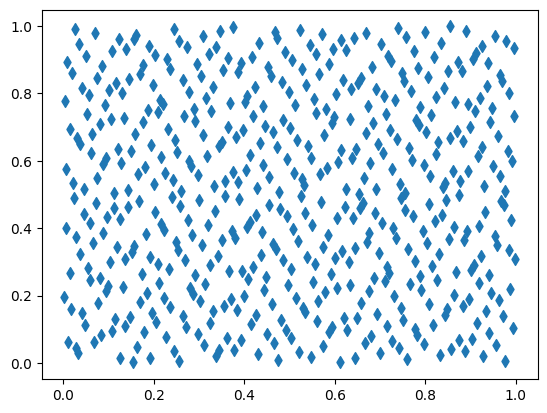

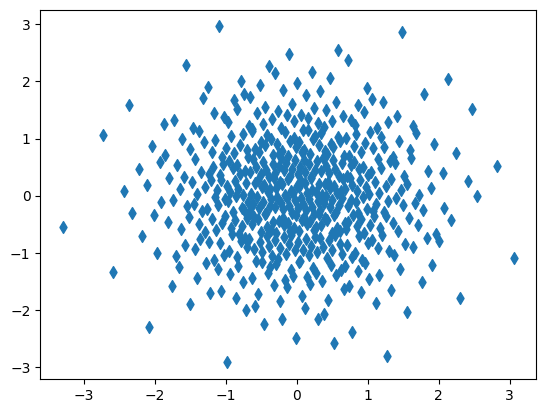

In [21]:
import scipy.stats as stats
from scipy.stats import qmc


def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)


def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)


x = sobol(m=9, d=2).T
print(f"Generated {x.shape}")

plt.scatter(x[0], x[1], marker="d")
plt.show()

x = sobol_norm(m=9, d=2).T
plt.scatter(x[0], x[1], marker="d")
plt.show()

If we apply QRN to the MC-based pricer, the variance is much smaller than the standard MC pricer with the same number of paths.


In [22]:
def mc_pricer_sobol(S_0, strike, ttm, rf, sigma, payoff_func, N, M):
    payoff = np.zeros(M)
    assert N == 1

    M2 = int(np.log2(M))
    delta_t = ttm / N
    z = sobol_norm(M2, N)
    # z = npr.normal(size=2 ** M2)
    zs = (rf - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * z
    print(z.shape)
    S = S_0 * np.exp(zs)
    payoff = payoff_func(S, strike).mean()
    df = np.exp(-rf * ttm)
    mc_pv = df * np.mean(payoff)
    mc_stdev = df * np.std(payoff) / np.sqrt(M)
    return mc_pv, mc_stdev


npr.seed(45109734)
print(estimate_price(bs_call))
print(estimate_price(mc_pricer))
print(estimate_price(mc_pricer_antithetic))
print(estimate_price(mc_pricer_sobol))

(19.38254929806086, 0, 0.0)
(19.36145555603002, 0.033854109881658996, -0.021093742030839024)
(19.37481877934614, 0.019637283601587566, -0.007730518714719636)
(524288, 1)
(19.38244705773596, 0.0, -0.0001022403248995829)


## Reference

The classic book on Monte Carlo methods in quantitative finance is:

Glasserman, P. (2004). Monte Carlo Methods in Financial Engineering. Springer.


##### Appendix: timestamp


In [23]:
from datetime import datetime

print(f"Generated on {datetime.now()}")

Generated on 2024-03-27 20:44:42.475816
